<a href="https://colab.research.google.com/github/GuptaTanay/Battery-Level-Prediction/blob/main/Battery_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot  as plt
from statsmodels.tsa.stattools import adfuller
# %%matplotlib_inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1. Load and understand the data

In [ ]:
data = pd.read_excel('BatteryLogs.xlsx')

In [ ]:
data.head()

,timestamp,scode,level
0,2021-04-23 07:44:08,3320e01c4f1d6fa898adbeda981150dc,6
1,2021-04-23 07:04:07,ea05a2a12ce40e29289cc6dd9587b665,7
2,2021-04-22 14:56:25,ca1441c0b8503ef6e77620bf602dae49,4
3,2021-04-22 14:47:49,ca1441c0b8503ef6e77620bf602dae49,4
4,2021-04-22 13:51:47,c47b970da888de5b0c0f299ed8a0cda7,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  585 non-null    object
 1   scode      585 non-null    object
 2   level      585 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.8+ KB


In [ ]:
data.scode.nunique()

24

In [ ]:
data.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
ea05a2a12ce40e29289cc6dd9587b665    27
c67cd9070c66fa4ba123d57c545bee28    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
547b07145a4af0bdcb026af8af3f5b05    14
7ebae810262304e22c8290f106bb9b7d    14
0057f94ed9cf672d1866745ca2324ac7    12
1be7b4ec4330e1fb03e56aa7e81368cb     6
bff3b24e342349f7eda673ee6228aeba     5
e4c48703b9319fd7b9132ff9080c69c3     3
f96ad41c1d11394382264ca085d21945     2
baee826a63b428981915076a9c6cd6a0     2
afd7215063859ee8ff44731986839859     2
cf84ad34de243829c53d5b3e83c500f5     2
58077f6af4a2135bd0c743dfa0b020a8     1
Name: scode, dtype: int64

2. Removing values less than 7

In [ ]:
counts = data.scode.value_counts()

res = data[~data.scode.isin(counts[counts < 7].index)]

In [ ]:
res.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
c67cd9070c66fa4ba123d57c545bee28    27
ea05a2a12ce40e29289cc6dd9587b665    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
7ebae810262304e22c8290f106bb9b7d    14
547b07145a4af0bdcb026af8af3f5b05    14
0057f94ed9cf672d1866745ca2324ac7    12
Name: scode, dtype: int64

In [ ]:
all_sessions = res['scode'].unique()
session_to_id_map = {}
for i in range(len(all_sessions)):
    session_to_id_map[all_sessions[i]] = 'id_' + str(i+1)

res['scode'] = res['scode'].map(session_to_id_map)
res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,timestamp,scode,level
0,2021-04-23 07:44:08,id_1,6
1,2021-04-23 07:04:07,id_2,7
2,2021-04-22 14:56:25,id_3,4
3,2021-04-22 14:47:49,id_3,4
4,2021-04-22 13:51:47,id_4,2
...,...,...,...
580,2020-07-30 07:27:30,id_8,5
581,2020-07-29 20:09:07,id_9,1
582,2020-07-29 19:57:52,id_9,2
583,2020-07-29 19:46:33,id_9,3


In [ ]:
res[['scode','level']].groupby(['level']).describe()

scode                   
      count unique    top freq
level                         
0         3      2   id_4    2
1        20      8   id_9    6
2        73      9   id_4   39
3        76     11   id_9   20
4        90     13  id_14   14
5       120     15  id_14   21
6       137     12  id_14   44
7        43     11   id_2   14

3.  Sorting based on timestamp column

In [ ]:
final_data = pd.DataFrame()

unique_scodes = res['scode'].unique()
for scode in unique_scodes:
    data_for_scode = res[ res['scode'] == scode ]
    data_for_scode = data_for_scode.sort_values(by='timestamp')
    final_data = final_data.append(data_for_scode)

final_data.groupby(['scode']).describe()

level                                               
      count      mean       std  min   25%  50%   75%  max
scode                                                     
id_1   21.0  4.571429  1.247855  1.0  4.00  5.0  5.00  7.0
id_10  14.0  5.642857  0.633324  5.0  5.00  6.0  6.00  7.0
id_11  33.0  3.757576  1.346994  1.0  3.00  4.0  5.00  7.0
id_12  23.0  3.478261  1.274561  1.0  3.00  3.0  4.50  6.0
id_13  27.0  2.888889  1.281025  1.0  2.00  3.0  3.50  7.0
id_14  89.0  5.561798  0.891310  4.0  5.00  6.0  6.00  7.0
id_15  12.0  3.666667  1.370689  1.0  2.75  4.0  5.00  5.0
id_16  14.0  5.642857  1.150728  3.0  5.00  5.5  6.75  7.0
id_2   27.0  6.259259  0.944319  4.0  6.00  7.0  7.00  7.0
id_3   24.0  4.291667  1.428869  0.0  3.75  4.0  5.00  7.0
id_4   51.0  2.078431  1.055332  0.0  2.00  2.0  2.00  6.0
id_5   40.0  4.825000  1.009887  2.0  4.00  5.0  6.00  6.0
id_6   76.0  4.828947  1.454997  2.0  4.00  5.0  6.00  7.0
id_7   26.0  5.884615  0.765607  4.0  5.25  6.0  6.00  7.0
id_8   46.0  4.543478  1.241979  1.0  4.00  5.0  5.00  7.0
id_9   39.0  2.615385  0.906566  1.0  2.00  3.0  3.00  4.0

In [ ]:
final_data.dtypes

timestamp    object
scode        object
level         int64
dtype: object

4.Moving timestamp to index column

In [ ]:
final_data['timestamp']=pd.to_datetime(final_data['timestamp'])

In [ ]:
final_data.dtypes

timestamp    datetime64[ns]
scode                object
level                 int64
dtype: object

In [ ]:
final_data.set_index('timestamp',inplace=True)

In [ ]:
final_data.head(20)

,scode,level
timestamp,,
2020-08-05 08:26:09,id_1,1
2020-09-02 10:54:22,id_1,4
2020-09-07 18:45:19,id_1,5
2020-09-08 17:34:04,id_1,5
2020-09-09 17:32:42,id_1,5
2020-09-17 09:27:40,id_1,5
2020-09-21 09:28:17,id_1,5
2020-09-22 11:49:22,id_1,4
2020-09-22 12:49:37,id_1,2


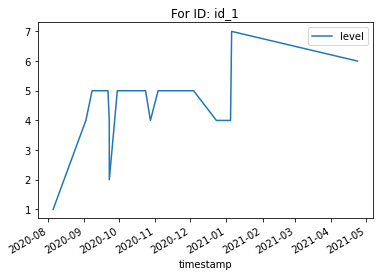

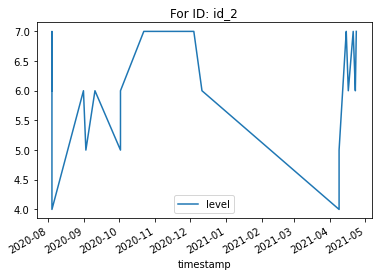

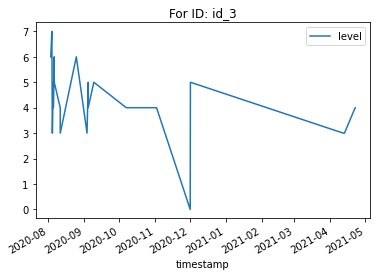

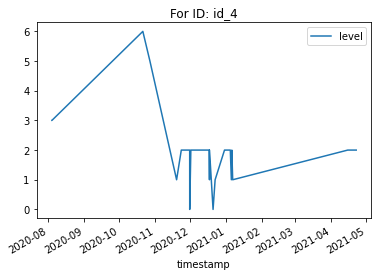

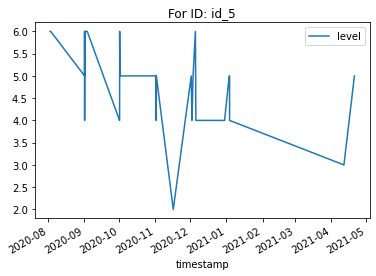

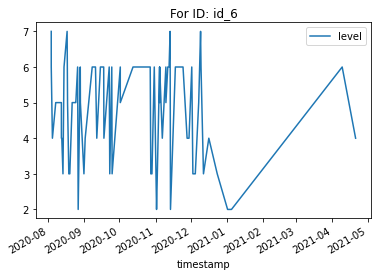

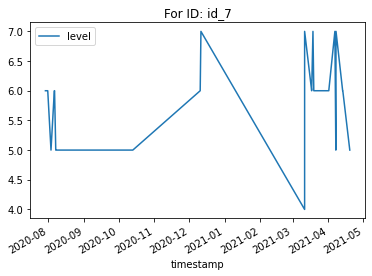

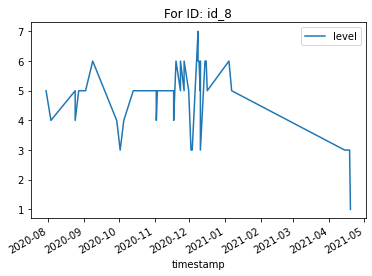

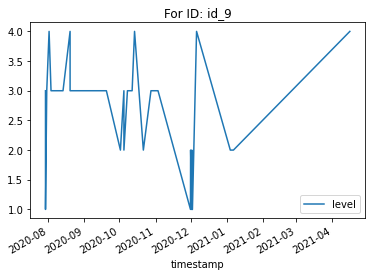

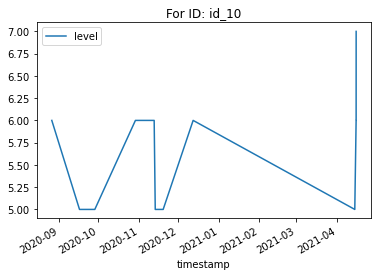

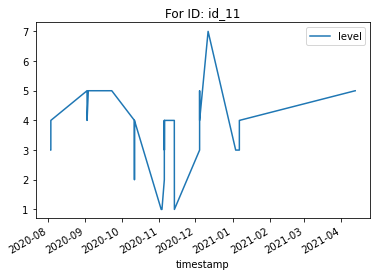

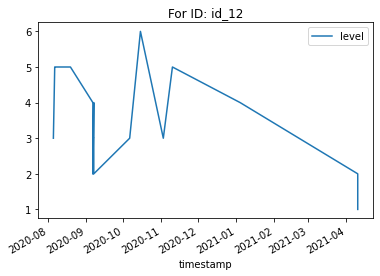

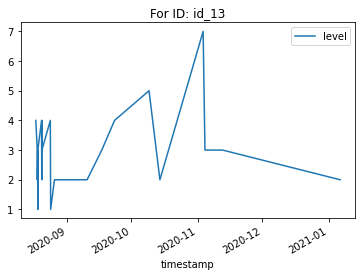

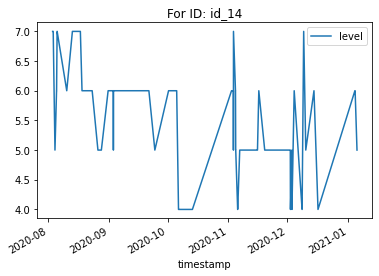

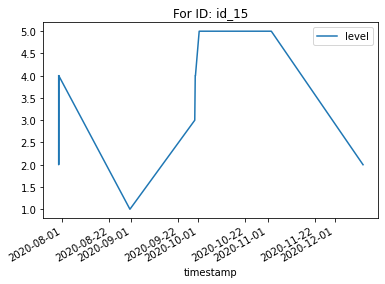

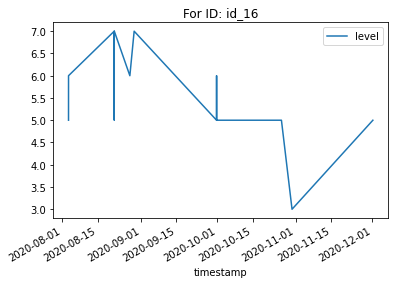

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    data_for_scode.plot(title = 'For ID: '+ str(scode))

In [ ]:
#Ho: It is non stationary
#H1: It is stationary
non_stationary = []
def adfuller_test(df, scode, add_to_non = False):
    result=adfuller(df)
    if result[1] > 0.05:
        print("Time series is non-stationary for: "+ scode)
        if add_to_non:
          non_stationary.append(scode)

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    adfuller_test(data_for_scode['level'], scode, True)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_9
Time series is non-stationary for: id_10
Time series is non-stationary for: id_12
Time series is non-stationary for: id_13
Time series is non-stationary for: id_15
Time series is non-stationary for: id_16


In [ ]:
# non_stationary
non_stationary = np.array(non_stationary, dtype='O')

In [ ]:
for i in non_stationary:
  data_for_scode = final_data[ final_data['scode'] == i ]
  # data_for_scode.plot(title = 'For ID: '+ str(i))
  data_for_scode['Seasonal First Difference']=data_for_scode['level']-data_for_scode['level'].shift(14)
  adfuller_test(data_for_scode['level'], i)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_9
Time series is non-stationary for: id_10
Time series is non-stationary for: id_12
Time series is non-stationary for: id_13
Time series is non-stationary for: id_15
Time series is non-stationary for: id_16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                            id_1


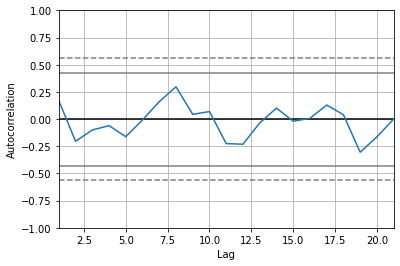

                            id_2


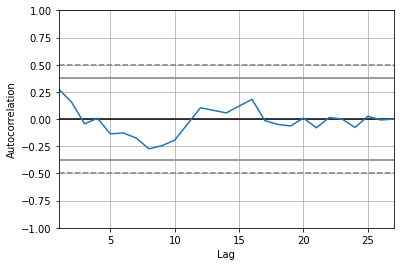

                            id_3


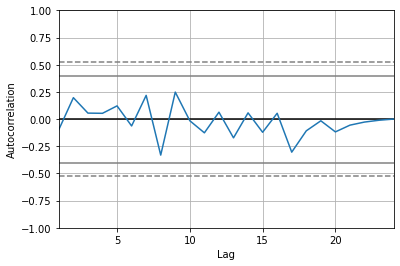

                            id_4


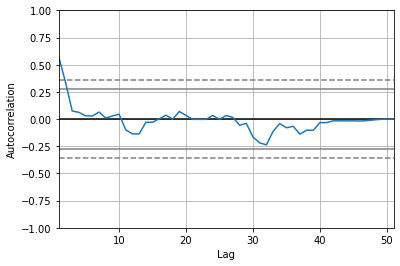

                            id_5


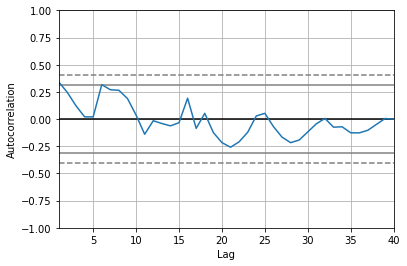

                            id_6


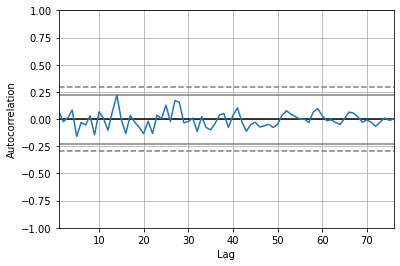

                            id_7


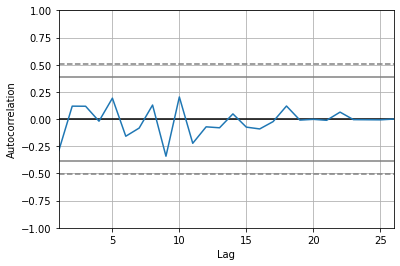

                            id_8


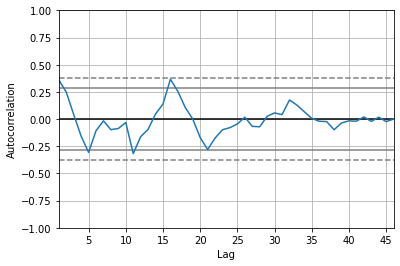

                            id_9


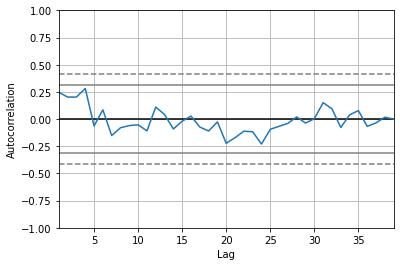

                            id_10


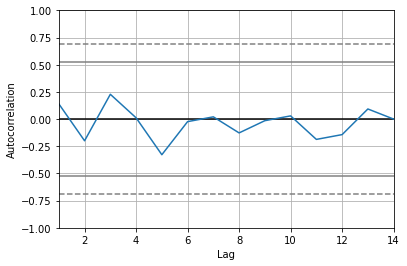

                            id_11


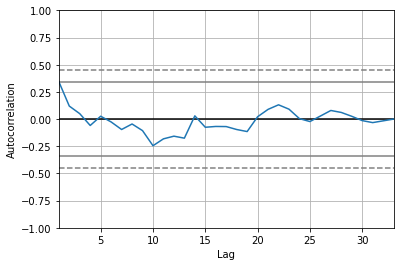

                            id_12


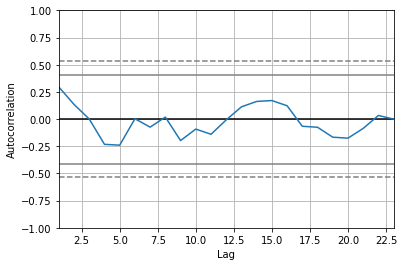

                            id_13


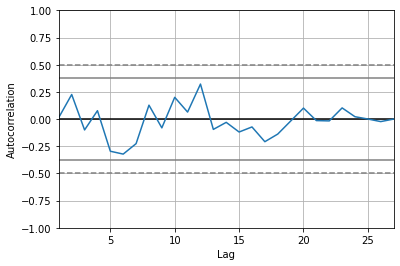

                            id_14


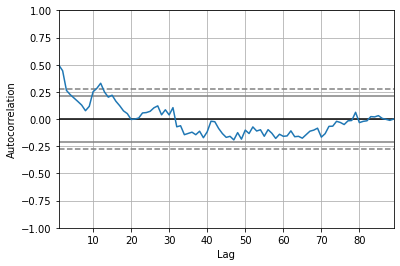

                            id_15


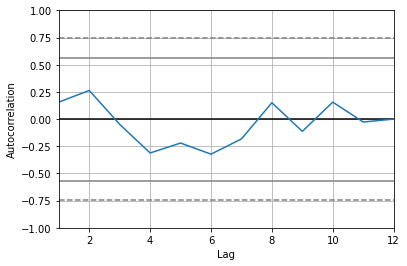

                            id_16


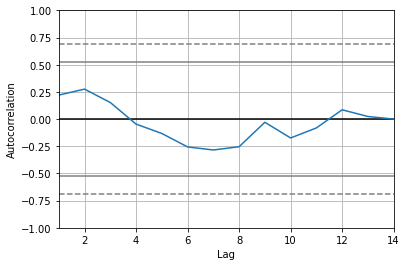

In [ ]:
#  selecting p value for each id
from pandas.plotting import autocorrelation_plot
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    print('                            '+scode)
    autocorrelation_plot(data_for_scode['level'])
    plt.show()  

In [ ]:
p_value = {'id_1': 0,
           'id_2': 0,
           'id_3': 0,
           'id_4': 1,
           'id_5': 1,
           'id_6': 0,
           'id_7': 1,
           'id_8': 0,
           'id_9': 0,
           'id_10': 0,
           'id_11': 0 ,
           'id_12': 0,
           'id_13': 0,
           'id_14': 2,
           'id_15': 0,
           'id_16': 0}

In [ ]:
# final_data
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# acf for p value of each id
# pacf for q value of each id

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


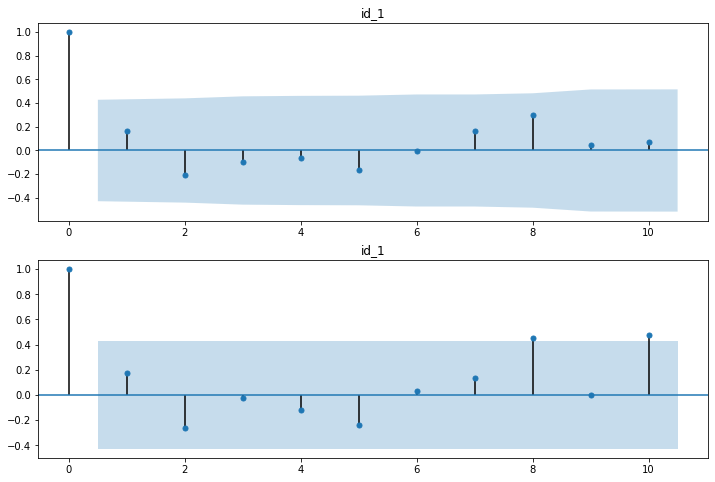

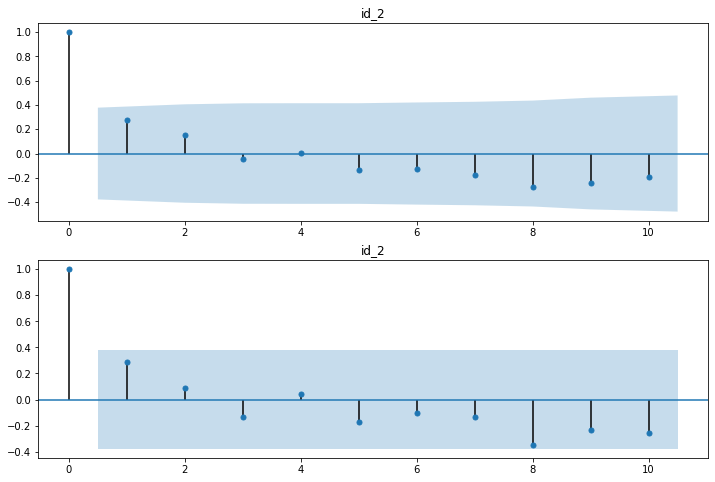

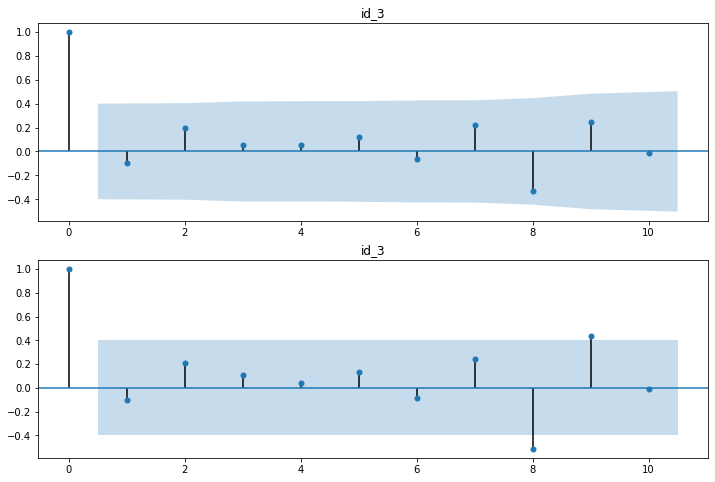

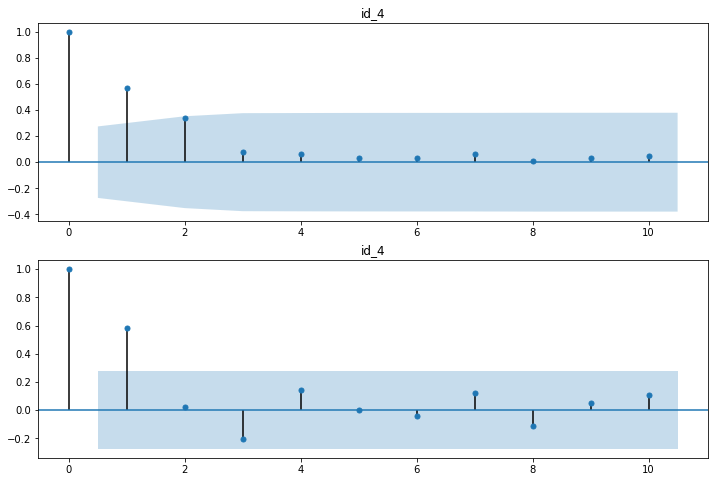

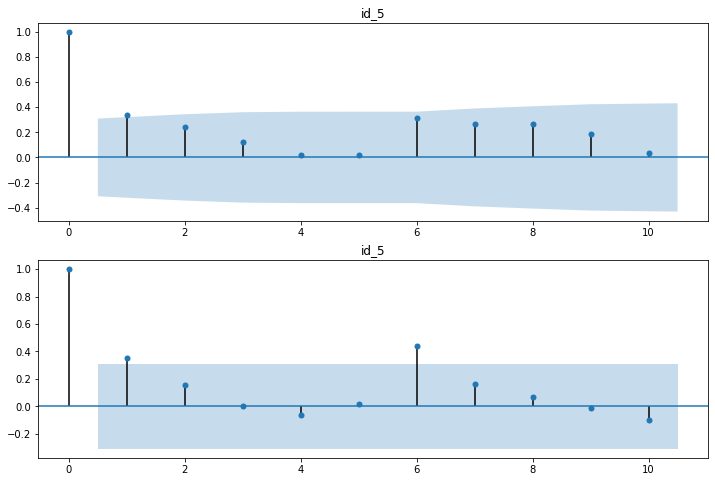

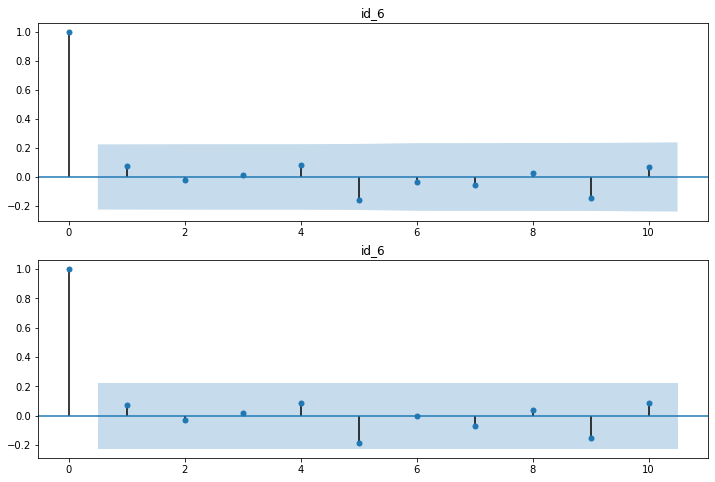

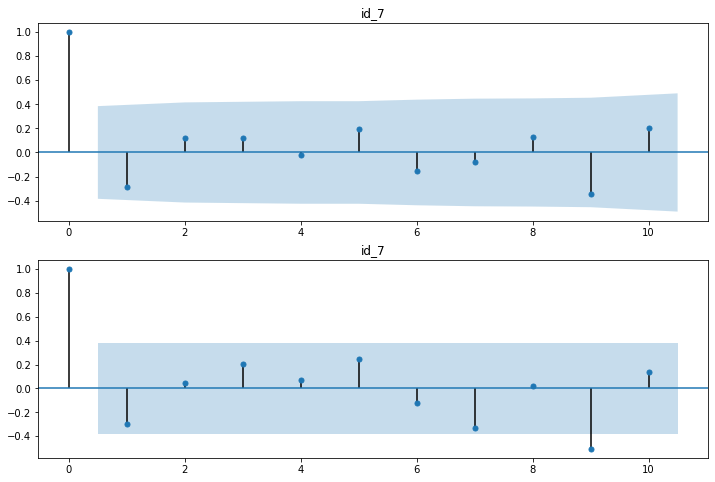

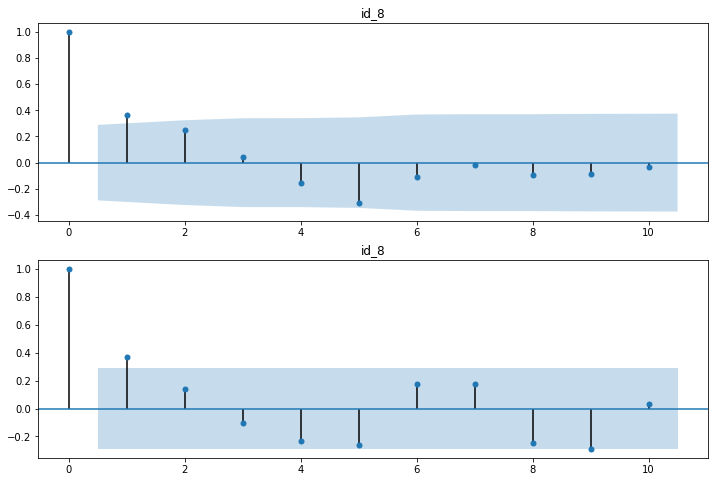

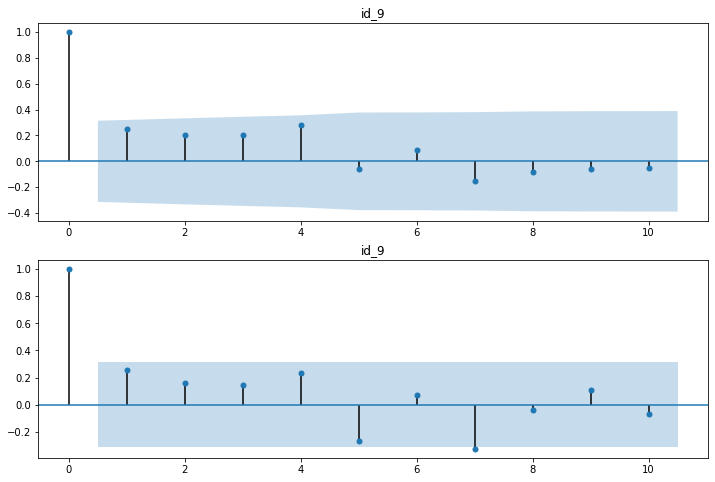

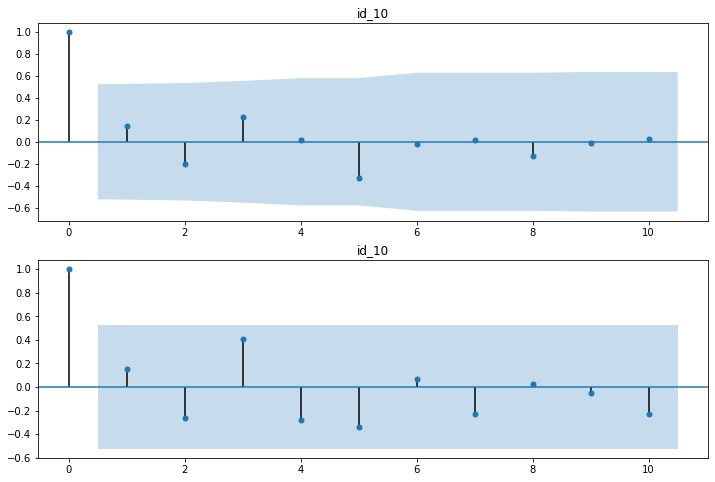

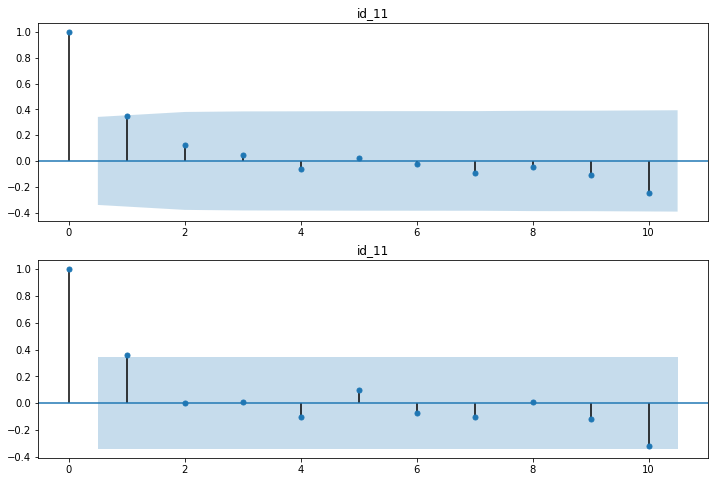

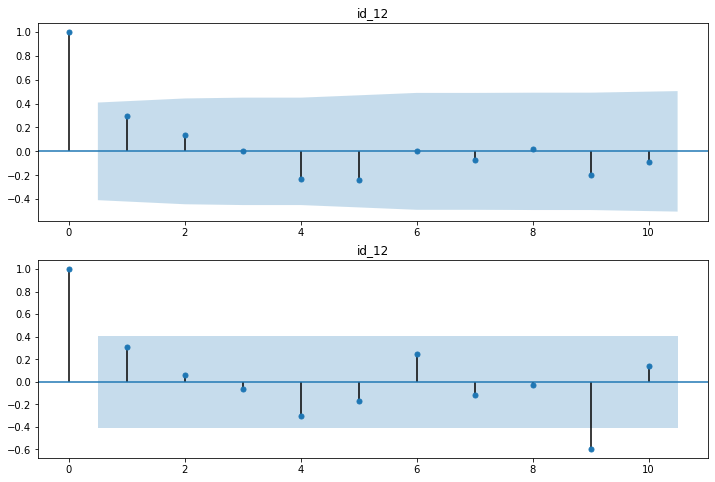

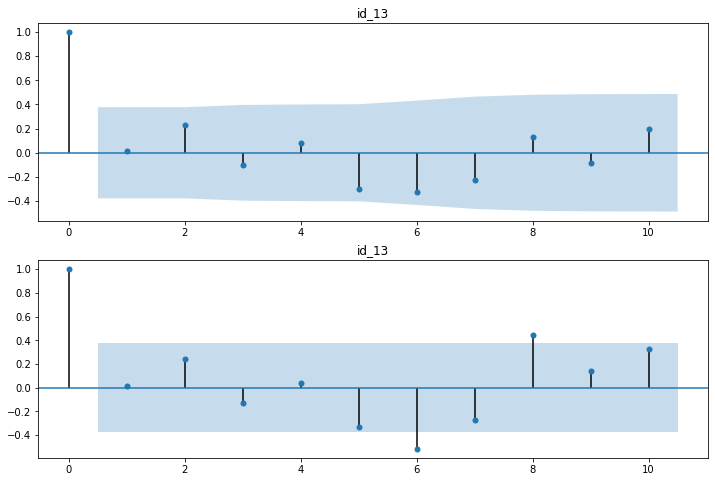

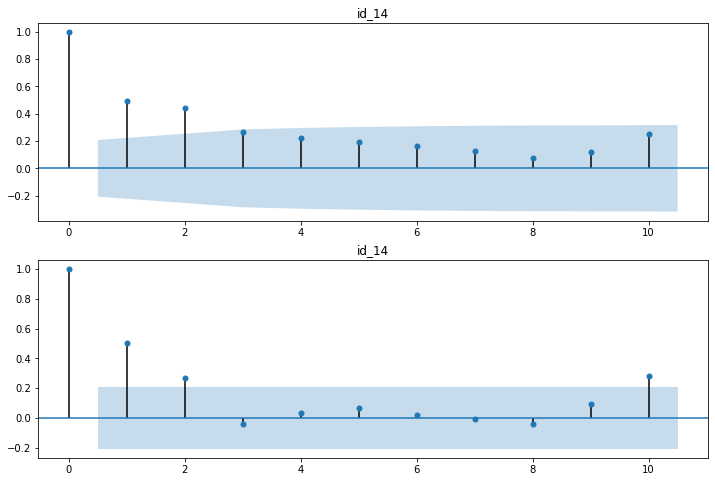

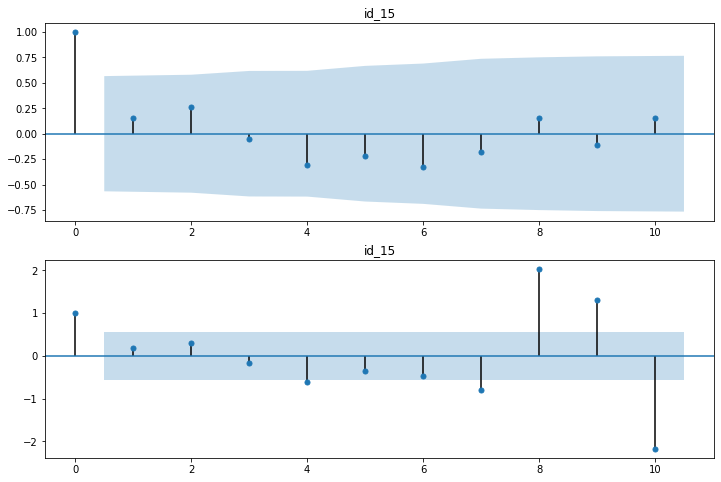

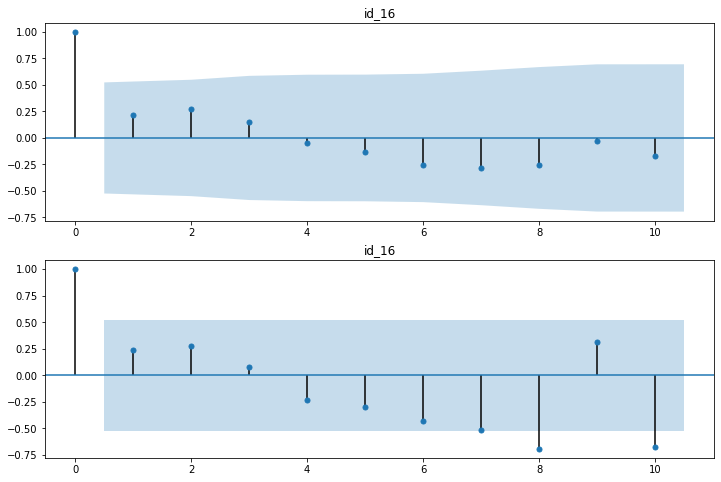

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data_for_scode['level'],lags=10,ax=ax1, title =scode)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data_for_scode['level'],lags=10,ax=ax2, title =scode)

In [ ]:
q = 1

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
    if scode in non_stationary or scode in ['id_6']:
      continue
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
    if scode in non_stationary or scode in ['id_6']:
      continue
    model=ARIMA(data_for_scode['level'],order=(0,0,0))
    model_fit=model.fit()
    print('--------------------------------')
    print('Model Summary for : ' +scode)
    print(model_fit.summary())
    # print('--------------------------------')    model=ARIMA(data_for_scode['level'],order=(0,0,0))
    # model_fit=model.fit()
    model_fit.predict()

--------------------------------
Model Summary for : id_1
                              ARMA Model Results                              
Dep. Variable:                  level   No. Observations:                   21
Model:                     ARMA(0, 0)   Log Likelihood                 -33.935
Method:                           css   S.D. of innovations              1.218
Date:                Sun, 08 Aug 2021   AIC                             71.871
Time:                        15:46:03   BIC                             73.960
Sample:                    08-31-2020   HQIC                            72.324
                         - 04-30-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5714      0.266     17.203      0.000       4.051       5.092
--------------------------------
Model Summary for : id_2
               

In [ ]:



df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [ ]:
def plot_curves(timestamps, actual_values, predicted_values):
    for session in actual_values.keys():
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        fig.suptitle('For session : ' + str(session))
        ts = timestamps[session]
        av = actual_values[session]
        pv = predicted_values[session]
        ax.plot(ts, av, label='Actual')
        ax.plot(ts, pv, label='Predicted')
        ax.set_ylim([0.5,7.5])
        ax.legend()
        
        plt.show()